# Car price prediction Midterm Project

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

from sklearn.tree import export_text
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score
import bentoml

In [2]:
df = pd.read_csv('resources/train.csv')

## 1. Cleaning and EDA

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns = df.columns.str.lower().str.replace(r'.', '', regex=True)

In [5]:
df.head()

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [6]:
df = df.drop(['id'], axis=1)
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

#convert values of all cols to lowercase
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df['mileage'] = df['mileage'].str.lower().str.replace('_km', '')

In [8]:
# split column into multiple columns by delimiter 
df['doors'] = df['doors'].str.split('-', expand=True)[0].str.replace('0', '')
df['doors'] = df['doors'].str.split('-', expand=True)[0].str.replace('>', '')
df['doors'] = df['doors'].astype(int)

In [9]:
df[['engine_volume', 'turbo']] = df['engine_volume'].str.split('_', expand=True)
df['turbo'] = df['turbo'].fillna('normal')
df['engine_volume'] = df['engine_volume'].astype(float)
df['levy'] = df['levy'].replace([r'-'], '', regex=True)
df['levy']= df['levy'].apply(pd.to_numeric)
df['levy']= df['levy'].fillna(0)
df['mileage'] = df['mileage'].astype(int)

In [10]:
df = df.sample(frac=1, random_state=1)

In [11]:
categorical = [
    'manufacturer',
    'model',
    'category',
    'leather_interior',
    'fuel_type',
    'gear_box_type',
    'drive_wheels',
    'wheel',
    'color'
]


numerical = [
    'engine_volume',
    'levy',
    'mileage',
    'prod_year',
    'cylinders',
    'airbags',
    'doors',
]

features = categorical + numerical

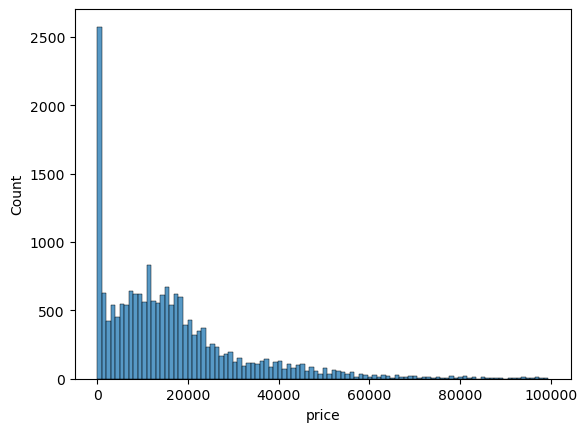

In [12]:
sns.histplot(df.price[df.price <100000], bins = 100)
plt.show()

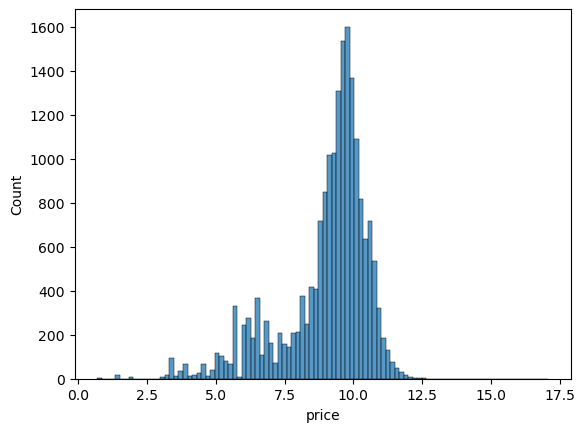

In [13]:
price_logs = np.log1p(df.price)
sns.histplot(price_logs, bins = 100)
plt.show()

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [16]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [17]:
val_dicts= df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

### 6.3 Random Forest

In [18]:
rf = RandomForestRegressor(n_estimators=120,
                            random_state=1,
                            max_depth=30,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=120, n_jobs=-1, random_state=1)

In [19]:
y_pred = rf.predict(X_val)

In [20]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(0.9629986467442875, 0.628345647027321)

## 7. Applying test dataset to selected model 

In [21]:
y_full_train = np.log1p(df_full_train.price.values)
del df_full_train['price']

In [22]:
full_train_dicts = df_full_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts= df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [23]:
rf = RandomForestRegressor(n_estimators=120,
                            random_state=1,
                            max_depth=30,
                            n_jobs=-1)
rf.fit(X_full_train, y_full_train)

RandomForestRegressor(max_depth=30, n_estimators=120, n_jobs=-1, random_state=1)

In [24]:
y_pred = rf.predict(X_test)

In [25]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

score, r2

(0.9466520166850689, 0.650294642423591)

## 8. Saving the model 

In [26]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = RandomForestRegressor(n_estimators=190,
                            random_state=1,
                            max_depth=30,
                            n_jobs=-1)
    model.fit(X_train, y_train)
    
    return dv, model

In [27]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict(X)
    
    return y_pred

In [28]:
dv, model = train(df_full_train, y_full_train)

In [29]:
y_pred = predict(df_test, dv, model)

In [30]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

score, r2

(0.9463966380297925, 0.6504832972537882)

In [33]:
bentoml.sklearn.save_model("car_price_prediction", model,
                          custom_objects={
                              "dictVectorizer": dv
                          })

Model(tag="car_price_prediction:d4dk7ic4po7ixahg", path="/Users/humbertorodriguez/bentoml/models/car_price_prediction/d4dk7ic4po7ixahg/")